In [23]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pylab import rcParams
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="paper", font_scale=1.5, rc=None)
sns.set(font="serif")

import plotly.express as px
import plotly.graph_objects as go

import geopandas as gpd


import libpysal as ps
from libpysal  import weights
from libpysal.weights import Queen

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights

from giddy.directional import Rose

import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation

from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error 

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

import warnings
warnings.filterwarnings('ignore') 
import time


In [24]:
pth_df = r"/Users/yuhan/Desktop/paper——revision/Dataprocess/jupitor/exported_data/states_sheldus_all.shp"

df_hazard_aggfips = gpd.read_file( pth_df )
print( df_hazard_aggfips.columns )


Index(['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'SOVI_SCORE', 'RESL_VALUE', 'fips', 'index',
       'HMAprojAmo', 'AdminCostA', 'NumfinalPr', 'CropDmg', 'CropDmg(AD',
       'CropDmgPer', 'PropertyDm', 'Property_1', 'Property_2', 'Injuries',
       'InjuriesPe', 'Fatalities', 'Fataliti_1', 'Duration_D', 'PAprojectA',
       'PDMprojAmo', 'PDMcount', 'PDMNumfina', 'HMAcount', 'HAtotal',
       'HAcount', 'PAcount', 'SBAcount', 'SBAProjcou', 'SBAapprove',
       'HazardCoun', 'x', 'y', 'geometry'],
      dtype='object')


In [25]:
df_hazard_aggfips.centroid
df_hazard_aggfips.centroid.x
df_hazard_aggfips.centroid.y


0       32.534932
1       30.736470
2       31.869615
3       32.998655
4       33.980880
          ...    
3103    41.659509
3104    43.934650
3105    41.287504
3106    43.905010
3107    43.840499
Length: 3108, dtype: float64

In [26]:
df_hazard_aggfips['x'] = df_hazard_aggfips.centroid.x
df_hazard_aggfips['x'] = df_hazard_aggfips.centroid.y
u = df_hazard_aggfips['x']
v = df_hazard_aggfips['x']
coords = list(zip(u,v))


In [27]:
X = df_hazard_aggfips[['POPULATION', 'BUILDVALUE', 'AGRIVALUE', 'SOVI_SCORE', 'PropertyDm']].values
X.shape

(3108, 5)

In [28]:
y = df_hazard_aggfips['HMAprojAmo'].values.reshape((-1,1)) # reshape is needed to have column array
y.shape


(3108, 1)

In [29]:
df_hazard_aggfips.head()

,STATE,STATEABBRV,COUNTY,COUNTYFIPS,STCOFIPS,POPULATION,BUILDVALUE,AGRIVALUE,SOVI_SCORE,RESL_VALUE,fips,index,HMAprojAmo,AdminCostA,NumfinalPr,CropDmg,CropDmg(AD,CropDmgPer,PropertyDm,Property_1,Property_2,Injuries,InjuriesPe,Fatalities,Fataliti_1,Duration_D,PAprojectA,PDMprojAmo,PDMcount,PDMNumfina,HMAcount,HAtotal,HAcount,PAcount,SBAcount,SBAProjcou,SBAapprove,HazardCoun,x,y,geometry
0,Alabama,AL,Autauga,001,01001,58764,9.123274e+09,24613998.0,51.299999,2.604995,1001,0.0,1208458.00,1497.0,164.0,350000.0,468266.65,9.80179,3.331930e+07,4.275979e+07,862.79546,85.0,0.00166,11.0,0.00019,77.0,0.0,0.00,0.0,0.0,6.0,7.687544e+06,4.0,0.0,44.0,6.0,1.160600e+06,56.0,32.534932,32.534932,"POLYGON ((-86.41284 32.63589, -86.41279 32.625..."
1,Alabama,AL,Baldwin,003,01003,231365,4.596848e+10,138089013.0,31.030001,2.745075,1003,1.0,95472063.21,392144.0,126.0,12800000.0,12854448.40,56.06272,3.020712e+09,3.158598e+09,14629.37470,83.0,0.00063,126.5,0.00081,177.0,0.0,678139.15,13.0,0.0,31.0,9.947442e+08,34.0,0.0,1634.0,35.0,1.577607e+09,146.0,30.736470,30.736470,"MULTIPOLYGON (((-87.92666 30.66002, -87.92688 ..."
2,Alabama,AL,Barbour,005,01005,25160,4.847697e+09,121075758.0,99.269997,2.383568,1005,2.0,21338.00,76.0,1.0,55000.0,56325.81,2.24697,1.709000e+06,2.254246e+06,76.66573,10.0,0.00035,0.0,0.00000,61.0,0.0,0.00,0.0,0.0,2.0,2.175617e+05,2.0,0.0,19.0,2.0,1.048000e+05,40.0,31.869615,31.869615,"POLYGON ((-85.25954 32.13837, -85.25882 32.138..."
3,Alabama,AL,Bibb,007,01007,22239,3.146947e+09,4819356.0,80.779999,2.471525,1007,3.0,2931436.47,8383.0,88.0,0.0,0.00,0.00000,8.862450e+07,1.041451e+08,4587.46150,76.0,0.00333,6.0,0.00024,62.0,0.0,0.00,0.0,0.0,3.0,2.454976e+07,4.0,0.0,55.0,4.0,4.280200e+06,41.0,32.998655,32.998655,"POLYGON ((-87.02581 33.21717, -87.02573 33.209..."
4,Alabama,AL,Blount,009,01009,58992,7.815620e+09,278570859.0,51.369999,2.488382,1009,4.0,1205206.70,62.0,67.0,5000.0,7385.54,0.14120,2.016735e+08,2.369050e+08,4121.46137,149.0,0.00265,1.0,0.00002,95.0,0.0,0.00,0.0,0.0,6.0,5.337763e+07,4.0,0.0,65.0,7.0,1.391430e+07,70.0,33.980880,33.980880,"POLYGON ((-86.44414 34.25913, -86.44434 34.256..."


In [30]:
nan_df = df_hazard_aggfips.isna().any(axis=1)
#print(df_hazard_aggfips[nan_df ] )

df_hazard_aggfips = df_hazard_aggfips.fillna(0)
nan_df = df_hazard_aggfips.isna().any(axis=1)
print(df_hazard_aggfips[nan_df ] )


Empty GeoDataFrame
Columns: [STATE, STATEABBRV, COUNTY, COUNTYFIPS, STCOFIPS, POPULATION, BUILDVALUE, AGRIVALUE, SOVI_SCORE, RESL_VALUE, fips, index, HMAprojAmo, AdminCostA, NumfinalPr, CropDmg, CropDmg(AD, CropDmgPer, PropertyDm, Property_1, Property_2, Injuries, InjuriesPe, Fatalities, Fataliti_1, Duration_D, PAprojectA, PDMprojAmo, PDMcount, PDMNumfina, HMAcount, HAtotal, HAcount, PAcount, SBAcount, SBAProjcou, SBAapprove, HazardCoun, x, y, geometry]
Index: []


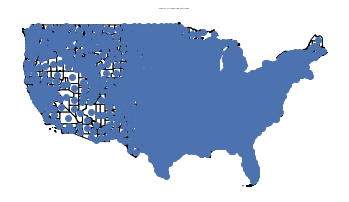

In [31]:

fig, ax = plt.subplots(figsize=(6, 6))
df_hazard_aggfips.plot(color = 'white', edgecolor = 'black', ax = ax)
df_hazard_aggfips.centroid.plot(ax=ax)
ax.set_title('Map of Georgia and centroids', fontsize= 2)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()



In [32]:
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search()

In [33]:
print('GWR bandwidth =', gwr_bw)


GWR bandwidth = 77.0


In [34]:
gwr_results = GWR(coords, y, X, gwr_bw).fit()


In [45]:

print('AIC =', gwr_results.aic)
print('AICc =', gwr_results.aicc)
gwr_results

AIC = 119384.68123410972
AICc = 119501.24504651812


In [36]:
df_hazard_aggfips['gwr_R2'] = gwr_results.localR2


In [37]:
df_hazard_aggfips['gwr_intercept'] = gwr_results.params[:,0]
df_hazard_aggfips['gwr_fb']        = gwr_results.params[:,1]
df_hazard_aggfips['gwr_aa']        = gwr_results.params[:,2]
df_hazard_aggfips['gwr_rural']     = gwr_results.params[:,3]

In [38]:
gwr_filtered_t = gwr_results.filter_tvals(alpha = 0.05)

pd.DataFrame(gwr_filtered_t)


,0,1,2,3,4,5
0,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,0.0,2.785069,0.0,-3.220496,0.0,33.917388
2,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,0.0,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...
3103,0.0,0.000000,0.0,0.000000,0.0,0.000000
3104,0.0,0.000000,0.0,0.000000,0.0,0.000000
3105,0.0,0.000000,0.0,0.000000,0.0,0.000000
3106,0.0,0.000000,0.0,0.000000,0.0,0.000000


In [39]:
gwr_filtered_tc = gwr_results.filter_tvals()
pd.DataFrame(gwr_filtered_tc)


,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,33.917388
2,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...
3103,0.0,0.0,0.0,0.0,0.0,0.000000
3104,0.0,0.0,0.0,0.0,0.0,0.000000
3105,0.0,0.0,0.0,0.0,0.0,0.000000
3106,0.0,0.0,0.0,0.0,0.0,0.000000


<Axes: >

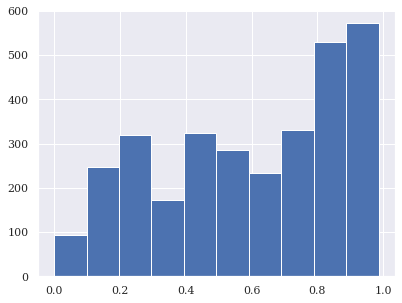

In [40]:
df_hazard_aggfips.loc[df_hazard_aggfips['gwr_R2'] < 0, 'gwr_R2'] = 0

df_hazard_aggfips.gwr_R2.hist()

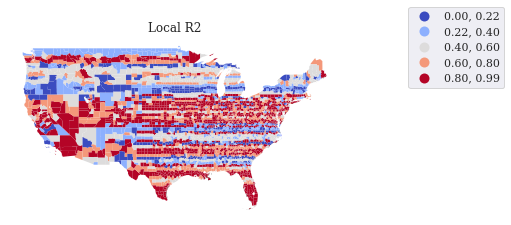

In [43]:

fig, ax = plt.subplots(figsize=(6, 6))
df_hazard_aggfips.plot(column='gwr_R2', cmap = 'coolwarm', linewidth=0.01, 
                       scheme = 'FisherJenks', k=5, legend=True, 
                       legend_kwds={'bbox_to_anchor':(1.30, 1.2)},  ax=ax)
ax.set_title('Local R2', fontsize= 12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()


In [46]:
gwr_p_values_stationarity = gwr_results.spatial_variability(gwr_selector, 500)


KeyboardInterrupt: 

In [ ]:
gwr_p_values_stationarity


In [47]:
LCC, VIF, CN, VDP = gwr_results.local_collinearity()


In [48]:
Zy = (y - y.mean(axis=0)) / y.std(axis=0)
ZX = (X - X.mean(axis=0)) / X.std(axis=0)


In [49]:
mgwr_selector = Sel_BW(coords, Zy, ZX, multi=True)
mgwr_bw = mgwr_selector.search()
mgwr_bw


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [30]:
mgwr_results = MGWR(coords, Zy, ZX, mgwr_selector).fit()


In [49]:

mgwr_results.summary()


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [32]:
mgwr_bw_ci = mgwr_results.get_bws_intervals(mgwr_selector)
print(mgwr_bw_ci)



[(57.0, 57.0), (52.0, 54.0), (52.0, 54.0), (2386.0, 3108.0), (2386.0, 3108.0), (44.0, 44.0)]


In [51]:
mgwr_results.params

NameError: name 'mgwr_results' is not defined

In [53]:
#POPULATION', 'BUILDVALUE', 'AGRIVALUE', 'SOVI_SCORE', 'PropertyDm

df_hazard_aggfips['mgwr_intercept']     = mgwr_results.params[:,0]
df_hazard_aggfips['mgwr_pop']           = mgwr_results.params[:,1]
df_hazard_aggfips['mgwr_bval']          = mgwr_results.params[:,2]
df_hazard_aggfips['mgwr_agval']         = mgwr_results.params[:,3]
df_hazard_aggfips['mgwr_sovi']          = mgwr_results.params[:,4]
df_hazard_aggfips['mgwr_damg']          = mgwr_results.params[:,5]


In [52]:
mgwr_results.params.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [37]:
mgwr_filtered_t = mgwr_results.filter_tvals(alpha = 0.05)
mgwr_filtered_t

array([[  0.        ,   2.96599385,  -2.40842324,   0.        ,
          0.        ,   0.        ],
       [ -2.85671594,  18.22653315, -14.96825492,   0.        ,
          0.        ,  30.44300244],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ]])

In [38]:
mgwr_filtered_tc = mgwr_results.filter_tvals()
mgwr_filtered_tc


array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  18.22653315, -14.96825492,   0.        ,
          0.        ,  30.44300244],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ]])

KeyError: 'mgwr_damg'

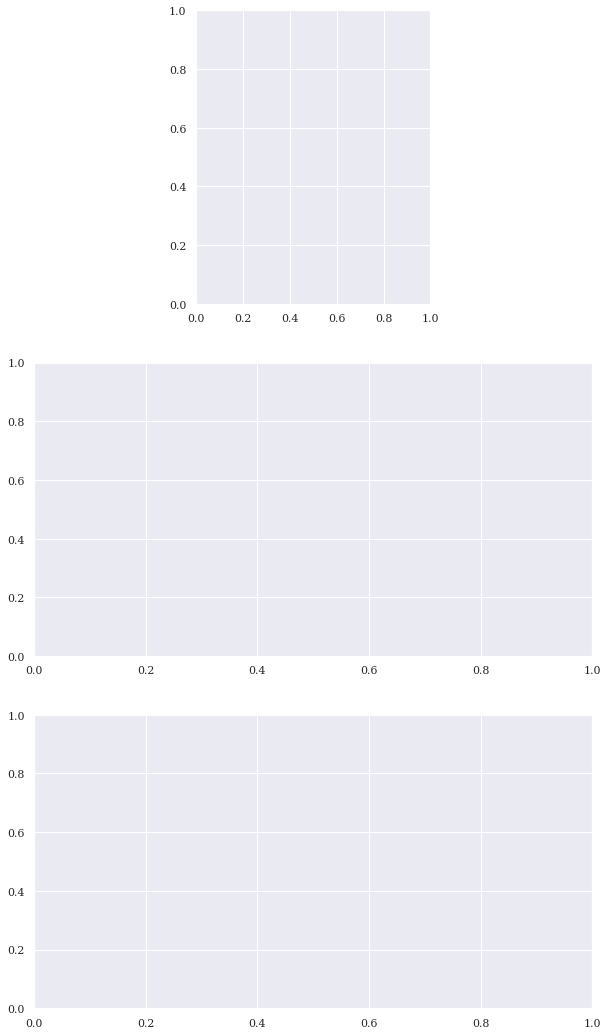

In [50]:
fig, axes = plt.subplots(nrows= 3, ncols= 1, figsize=(10,18))

df_hazard_aggfips.plot(column='mgwr_damg', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[0])


df_hazard_aggfips.plot(column='mgwr_sovi', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[1])
df_hazard_aggfips[mgwr_filtered_tc[:,4] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])


df_hazard_aggfips.plot(column='mgwr_damg', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[2])
df_hazard_aggfips[mgwr_filtered_tc[:,5] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) MGWR: Foreign born (BW: ' + str(mgwr_bw[1]) +'), all coeffs', fontsize=12)
axes[1].set_title('(b) MGWR: Foreign born (BW: ' + str(mgwr_bw[1]) +'), significant coeffs',     fontsize=12)
axes[2].set_title('(c) MGWR: Foreign born (BW: ' + str(mgwr_bw[1]) +'), significant coeffs and corr. p-values',     fontsize=12)
plt.show()


In [44]:
mgwr_results.params.shape

(3110, 6)